In [35]:
!conda install gensim -y >> ~/gensim.log

### Representations of Words and Documents

* This section is about feature engineering schema for documents of text.

* Applications: 
    * Document classification
    * Analogies
    * Word similarities
    * Language models
    * "Reverse Dictionaries"
    
* Methods we will cover:
    * Document Term Matrices
    * Weighting Schemes
    * Term-Context Matrices
    * Dimensionality Reduction (Latent Semantic Analysis)
    * Feature hashing
    * Neural embeddings    

### A note before starting...

* Word representation $\neq$ Document Representation
* When training supervised model $f$ on documents:
    * $f(\text{representation of document})$ where f can be any typical classifier
        * N x K Matrix
    * $f(\text{aggregator(array of representations of words})$ where f can be any typical classifier
        * N x K Matrix    
    * $f(\text{array of representations of words})$ where f is a neural network.
        * N x M x K Matrix    

### Success Criteria
* Performs well on the given task
* Similar words and documents are represented by points close in space.
* Few examples needed to learn (Winner -> Feature Hashing)
* Quick to learn/implement (Winner -> Feature Hashing, DTM)
* Easy to store (low dimensional) (Winner -> LSA)
* Generalizes to new documents (Winner -> Feature Hashing, LSA, Neural Embeddings)
* Generalizes to other tasks (Winner -> Neural Embeddings)

### A Simple Representation: Document Term Matrices:


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

    
verbs = ['like','likes','play','plays']
sports = ['baseball','soccer','football','golf','tennis']
pronouns = {
    'he':['plays','likes'],
    'she':['plays','likes'],
    'they':['play','like'],
    'we':['play','like'],
    'i':['play','like']
}

choose = lambda x: np.random.choice(x)

def build_clause():
    pronoun = choose(list(pronouns.keys()))
    verb = choose(pronouns[pronoun])
    sport = choose(sports)
    return " ".join([pronoun, verb, sport])
    
sentences = [build_clause() for i in range(20000)]


toDTM = CountVectorizer(lowercase=False)
DTM = toDTM.fit_transform(sentences).todense()
words = toDTM.get_feature_names()

dtm_summary = pd.DataFrame(DTM, columns = words, index = sentences)
dtm_summary.head()

,baseball,football,golf,he,like,likes,play,plays,she,soccer,tennis,they,we
we play football,0,1,0,0,0,0,1,0,0,0,0,0,1
we like tennis,0,0,0,0,1,0,0,0,0,0,1,0,1
we play baseball,1,0,0,0,0,0,1,0,0,0,0,0,1
she likes golf,0,0,1,0,0,1,0,0,1,0,0,0,0
i like football,0,1,0,0,1,0,0,0,0,0,0,0,0


### Improving upon Counts with TFIDF
* Informative v noninformative words
* Weight words in a way that helps us distinguish documents.
* **TFIDF**: Weight words based on their frequency within a document, discounted by their frequency elsewhere.

In [109]:
#This example doesnt best show case tfidf...
from sklearn.feature_extraction.text import TfidfVectorizer
toTFIDF = TfidfVectorizer(lowercase=False)
TFIDF = toTFIDF.fit_transform(sentences).todense()
words = toTFIDF.get_feature_names()

tfidf_summary = pd.DataFrame(TFIDF, columns = words, index = sentences)
tfidf_summary.head()

,baseball,football,golf,he,like,likes,play,plays,she,soccer,tennis,they,we
we play football,0.000000,0.607764,0.000000,0.0,0.000000,0.000000,0.514199,0.0,0.000000,0.0,0.000000,0.0,0.605162
we like tennis,0.000000,0.000000,0.000000,0.0,0.516256,0.000000,0.000000,0.0,0.000000,0.0,0.607641,0.0,0.603533
we play baseball,0.605683,0.000000,0.000000,0.0,0.000000,0.000000,0.515228,0.0,0.000000,0.0,0.000000,0.0,0.606373
she likes golf,0.000000,0.000000,0.576835,0.0,0.000000,0.574436,0.000000,0.0,0.580762,0.0,0.000000,0.0,0.000000
i like football,0.000000,0.761290,0.000000,0.0,0.648412,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


### Reducing High Dimensionality:
* Heap's law: $vocabsize = k\cdot ntokens^{\beta}$
    * K usually $\in$ (10, 100)
    * $\beta$ usually $\in$ (0.4, 0.6)
* Improve Generalizability
    * e.g. learning [sports] rather than baseball, basketball, etc...

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


Size of vocabulary = 2.28*n_tokens^(0.80)


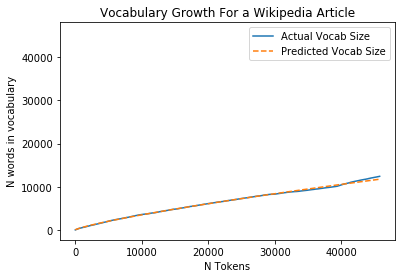

In [111]:
!conda install wikipedia -y>> ~/wikipedia.log
%matplotlib inline
import matplotlib.pyplot as plt
import wikipedia
import re
import numpy as np

page = wikipedia.page("List_of_Dutch_inventions_and_discoveries")
words = re.split("\s", page.content)


counts = []
for i in range(len(words)):
    counts.append(len(set(words[:i])))
counts = np.array(counts)

from scipy.optimize import minimize

def heap_error(arg):
    k, beta = arg
    heap_estimate = lambda x: k * x **(beta)
    predictions = np.array(list(map(heap_estimate, range(len(words)))))
    return np.mean(abs(predictions - counts))
optimal_params  = minimize(heap_error, (50, .5))
k, beta = optimal_params['x']
heap_estimate = lambda x: k * x **(beta)


f, ax = plt.subplots(1)
ax.plot(counts, label="Actual Vocab Size")
ax.set_ylim(ax.get_xlim())

predicted_word_counts = np.array(list(map(heap_estimate, range(len(words)))))
ax.plot(predicted_word_counts, linestyle="--", label='Predicted Vocab Size')
ax.set_xlabel("N Tokens")
ax.set_ylabel("N words in vocabulary")
ax.set_title("Vocabulary Growth For a Wikipedia Article")
plt.legend()
print("Size of vocabulary = {0:.2f}*n_tokens^({1:.2f})".format(k, beta))

### Feature Hashing for faster (stateless) transformations
* Weinberger et al https://arxiv.org/pdf/0902.2206
* Solves the need to observe the whole dataset first to build a vocabulary dictionary.


* To vectorize a document:
    * Define number of dimensions K
    * Pick a hasher (MurmurHash3)
    * define F(word): hasher(word) % K
    * create empty vector V with K slots.
    * For word in document:
        * V[F(word)] += 1

* How many features to use?
    * Lots
    * Want to ensure 0 collisions

In [201]:
try:
    import mmh3
except ModuleNotFoundError:
    !pip install mmh3 >> ~/mmh3.log
from ipywidgets import Textarea, HBox, VBox, Button, IntSlider
from IPython.display import display
from IPython.display import clear_output
import mmh3
class Hasher(object):
    def __init__(self):
        self.textarea = Textarea("This is a document")
        self.slider = IntSlider(description="Number of Features", min=1, value=3)
        self.vectorize_button = Button(description="Vectorize")
        self.vectorize_button.on_click(self.vectorize)
        self.out = Output()
        self.stuff = VBox([self.textarea, self.slider, self.vectorize_button, self.out])
        display(self.stuff)
        
    @property
    def n_features(self):
        return self.slider.value
        
    @property
    def text(self):
        return self.textarea.value
    
    def hash_transform(self, word):
        return mmh3.hash(word) % self.n_features
    
    def vectorize(self, b):
        if self.text:
            
            vector = np.zeros(self.n_features)
            word_hash = {}
            with self.out:
                clear_output()
                for word in self.text.split(" "):
                    val = self.hash_transform(word)
                    word_hash[word] = val
                    vector[val] += 1
                n_collisions = len(word_hash.values()) - len(set(word_hash.values()))
                print("Hashing vectorizer with {0} features produced {1} collisions".format(self.n_features, n_collisions))
                print()
                print("Transformed Document:")
                print(vector)
                
        
c = Hasher()        

In [210]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer()
hashed_corpus = hv.transform(sentences)
hashed_corpus

<20000x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 56102 stored elements in Compressed Sparse Row format>

### Dimensionality Reduction

* E.G. Latent Semanic Analysis

In [202]:
from sklearn.decomposition import PCA

k = 5
pca = PCA(n_components=k)
toDTM = CountVectorizer(lowercase=False)
DTM = toDTM.fit_transform(sentences).todense()
DTM_Rep = pca.fit_transform(DTM)
words = toDTM.get_feature_names()

lsa_summary = pd.DataFrame(DTM_Rep, columns = ['PCA {}'.format(i) for i in range(k)], index = sentences)
lsa_summary.head()

,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4
we play football,-0.630775,-0.690276,-0.397072,0.547386,-0.401107
we like tennis,-0.627412,0.744276,-0.489158,0.413051,-0.436502
we play baseball,-0.654647,-0.690757,0.348544,0.010884,-0.144642
she likes golf,0.765729,-0.016580,-0.102886,0.031554,-0.186356
i like football,-0.302798,0.718161,-0.080361,0.275443,-0.229374


### What about local context?
* We've been treating words within a document as exchangeable, iid.

* We've been ignoring word context:
    * I play [sports|football|soccer], and I watch [Star Wars | movies | Lord of the Rings].
    * "play" is coupled with sports, "watch" is coupled with movies.
    * Document based vectorization ignores this.
    
**The Claim**: Words that are semantically similar should have similar contexts (aka the distributional hypothesis).    


### Local Context Matrices
* aka Co-Occurance Matrices

* To build word vectors:
    * Build a co-occurance matrix, reduce dimensionality with SVD

In [92]:
def flatten(array):
    return [item for subarray in array for item in subarray]

class CoOccurangeVectorizer(object):
    def __init__(self, window_size = 3):
        
        self.vocab = None
        self.vocab_size = None
        self.window_size = window_size
        self.matrix = None
        self.feature_names = None
        
        self._fitted = False

    def fit(self, documents):
        
        self.feature_names = list(set(flatten(documents)))
        self.vocab = {token: i for i, token in enumerate(self.feature_names)}
        self.vocab_size = len(self.feature_names)
        self.matrix = scipy.sparse.lil_matrix((self.vocab_size, self.vocab_size))
        
        for document in documents:
            for i, token in enumerate(document):
                token_id = self.vocab.get(token)
                window = slice(max(0, i - self.window_size), self.window_size)
                for c_token_id in map(self.vocab.get, document[window]):
                    self.matrix[token_id, c_token_id] += 1
        self.matrix.diagonal = 0
        self._fitted = True
        return self.matrix
        

In [211]:
#Co-occurances
from sklearn.decomposition import TruncatedSVD
a = CoOccurangeVectorizer()
cooccurance_matrix = a.fit([i.split() for i in sentences])
pd.DataFrame(cooccurance_matrix.todense(), index=a.feature_names, columns = a.feature_names)

,he,i,play,she,golf,likes,football,soccer,plays,they,tennis,baseball,like,we
he,4131.0,0.0,0.0,0.0,834.0,2095.0,850.0,828.0,2036.0,0.0,813.0,806.0,0.0,0.0
i,0.0,3898.0,1931.0,0.0,784.0,0.0,752.0,770.0,0.0,0.0,756.0,836.0,1967.0,0.0
play,0.0,1931.0,5988.0,0.0,1232.0,0.0,1167.0,1189.0,0.0,2003.0,1168.0,1232.0,0.0,2054.0
she,0.0,0.0,0.0,3981.0,788.0,2001.0,840.0,745.0,1980.0,0.0,793.0,815.0,0.0,0.0
golf,834.0,784.0,1232.0,788.0,4052.0,814.0,0.0,0.0,808.0,802.0,0.0,0.0,1198.0,844.0
likes,2095.0,0.0,0.0,2001.0,814.0,4096.0,846.0,809.0,0.0,0.0,812.0,815.0,0.0,0.0
football,850.0,752.0,1167.0,840.0,0.0,846.0,4008.0,0.0,844.0,755.0,0.0,0.0,1151.0,811.0
soccer,828.0,770.0,1189.0,745.0,0.0,809.0,0.0,3893.0,764.0,779.0,0.0,0.0,1131.0,771.0
plays,2036.0,0.0,0.0,1980.0,808.0,0.0,844.0,764.0,4016.0,0.0,794.0,806.0,0.0,0.0
they,0.0,0.0,2003.0,0.0,802.0,0.0,755.0,779.0,0.0,3937.0,768.0,833.0,1934.0,0.0


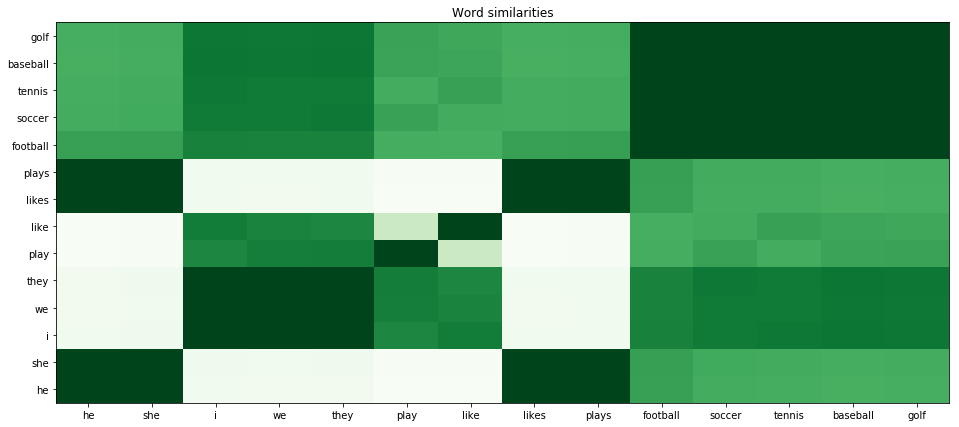

In [225]:
#word vectors (and similaries of results)
import matplotlib.pyplot as plt
toks = ['he', 'she', 'i', 'we', 'they',  'play', 'like',  'likes', 'plays', 'football', 'soccer',  'tennis', 'baseball', 'golf']

svd = TruncatedSVD(3)
cooccurance_svd = svd.fit_transform(cooccurance_matrix)
word_similaries = pd.DataFrame(cosine_similarity(cooccurance_svd), index=a.feature_names, columns=a.feature_names)
word_similaries = word_similaries[toks].loc[toks]

f, ax = plt.subplots(1, figsize = (16, 7))
plt.pcolor(word_similaries, cmap="Greens")
plt.yticks(np.arange(0.5, len(word_similaries.index), 1), word_similaries.index)
plt.xticks(np.arange(0.5, len(word_similaries.columns), 1), word_similaries.columns)
plt.title("Word similarities")
plt.show()

$\approx$

### Neural Embeddings
While matrix factorization over (word, context) matrices solved some key challenges, we see better performance from using neural architectures for learning word representations.

**How is it different than SVD((word, context) matrices)? **

    * The vectors are contructed via a "supervised process"
    
**Theoretical Motivation**:
* Distributional hypothesis: similar words will have similar contexts | words with similar contexts are similar
    
**The strategy**: 
* Build a model that relies on word vectors. Training will update the word vectors.
* Have the model rely on a word's vector to predict its context (or visa versa)
* Vectors that predict context $\approx$ Vectors that predict semantics

**The implication:** Therefore, representing a words context well will provide a good representation of its underlying semantics.
<center>
<h3> Continuous Bag of Words (CBOW) Word2Vec: </h3>
</center>
![NN](assets/softmax-nplm.png)
![NN](assets/BengioNN.png)


### Evaluating word vectors:
* Extrinsic:
    * Use them for the task at hand!
    * E.g. use vectors to train a model, look at performance.
    * problem:
        * We dont know how to decompose errors into bad vectors vs bad model
* Intrinsic:
    * Completing analogies $\rightarrow$ A:B :: C:???
    * e.g. boy:girl :: man: ????
    * approach:
        * define "relationship" as (B-A)
        * translate C: C + "relationship"
        * find word D whose vector is closest to C + "relationship"
        
        * $d = \underset{i}{\mathrm{argmin}} \frac{(x_b - x_a + x_c)^T x_i}{||x_b - x_a + x_c||}$

### Using Gensim to implement Word2Vec, a neural embedding model.

### Exercise 1:
* Process a corpus with SpaCy
* Build a Word2Vec model with 
Train your own word2vec model using dataset, and load those vectors into spacy. Visually inspect the results of the vector as a self organizing map.

#### Gotchas and notes:
* Due to the way the binary vector files are read and written, only single word lexemes can be mapped to a vector.

In [1]:
try:
    import spacy
except ModuleNotFoundError:
    !conda install spacy -y
    import spacy

if 'nlp' not in globals():
    nlp = spacy.load('en')

if nlp.parser is None:
    !python -m spacy download en >> ../spacy-download.log
    nlp = spacy.load('en')
try:
    from gensim.models import Word2Vec
except ModuleNotFoundError:
    !conda install gensim -y    
    from gensim.models import Word2Vec    


from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups()
corpus = dataset.data

In [2]:
from spacy.tokens import Doc
import spacy
from spacy.matcher import Matcher
from spacy.attrs import ORTH, IS_PUNCT
try:
    from skater.util.progressbar import ProgressBar
except ModuleNotFoundError:
    !conda install skater > ~/skater.log
    from skater.util.progressbar import ProgressBar
    
        
class TextProcesser(object):
    
    def __init__(self, nlp=None):
        self.nlp = nlp or spacy.load('en')
        
    def __call__(self, corpus, merge_ents=False, matcher=None):
        p = ProgressBar(len(corpus))
        for doc in self.nlp.pipe(corpus, parse=False, tag=bool(merge_ents)):
            p.animate()
            if matcher:
                matcher(doc)
            if merge_ents:
                for ent in doc.ents:
                    ent.merge()
            yield list(map(self.process_token, doc))
            
    def process_token(self, token):
        if token.like_url:
            return 'URL'
        elif token.like_email:
            return 'EMAIL'
        elif token.like_num:
            return 'NUM'
        else:
            return token.lower_

In [3]:
from spacy.attrs import LOWER
matcher = Matcher(nlp.vocab)
matcher.add_entity('Twitter')
matcher.add_pattern("Twitter", [{LOWER: "twitter"},])
processor = TextProcesser(nlp=nlp)
print(list(processor(["Lets go to New York."])))

[1/1] iterations ████████████████████ Time elapsed: 0 seconds[['lets', 'go', 'to', 'new', 'york', '.']]


In [4]:
# I take 1-2 minutes :)
processed_sents = list(processor(corpus))

[11314/11314] iterations ████████████████████ Time elapsed: 58 seconds

In [5]:
model = Word2Vec(sentences=processed_sents, ###tokenized senteces, list of list of strings
                 size=256,  #size of embedding vectors
                 workers=8, #how many threads?
                 min_count=5, #minimum number of token instances to be considered
                 sample=0, #weight of downsampling common words? 
                 sg = 0, #should we use skip-gram? if 0, then cbow
                 hs=0, #heirarchical softmax?
                 iter=5 #training epocs
        )

# to save:
# with open('gensim-model.pkl', 'wb') as model_file:
#    model.save(model_file)
    
    


### How similar are words according to each embedding model (Ours vs Default Spacy)?


##### Similarly on general, generic words:

In [70]:
import pandas as pd
def compare_sims(word, gensim_model, nlp):
    our_sims = gensim_model.most_similar(word)
    spacy_sims = [(other_word, nlp(other_word).similarity(nlp(word))) for other_word in [i[0] for i in gensim_model.most_similar(word)]]

    spacy_sims = pd.Series([i[1] for i in spacy_sims], index = [i[0] for i in spacy_sims])
    our_sims = pd.Series([i[1] for i in our_sims], index = [i[0] for i in our_sims])

    sims = pd.DataFrame({'SpaCy Similarities': spacy_sims, 'Our Similarities': our_sims})
    return sims
compare_sims('that', model, nlp)

,Our Similarities,SpaCy Similarities
which,0.704645,0.832235
simply,0.602284,0.703956
because,0.583248,0.840885
whether,0.583130,0.749810
what,0.566310,0.822552
probably,0.563854,0.698149
certainly,0.561976,0.733838
where,0.560348,0.757477
usually,0.534817,0.570722
since,0.532170,0.553669


#### Less Similar on more Corpus Specific Terms:

In [268]:
compare_sims('hockey', model, nlp)

,Our Similarities,SpaCy Similarities
baseball,0.756164,0.683179
playoff,0.755581,0.527053
league,0.722711,0.611304
winning,0.699843,0.329621
nhl,0.681338,0.000000
coverage,0.643939,0.209983
team,0.640732,0.485323
games,0.624865,0.482595
pitching,0.619377,0.000000
game,0.614022,0.469263


### Exercise:  Load Vector Model into Spacy:
* Steps:
    * Save to word2vec format: 
        * [word1] [val1] [val2] ....
        * [word2] [val1] [val2] ....
    * remove first row, which contains metadata (n_words, n_dim), and any blank line
    * Compress data, write to file
    * Use Spacy to `Write binary vectors`

In [67]:
#This part is a bit awkward...
import bz2
import spacy

#write to disk
vector_file = 'custom-vectors.word2vec'
model.wv.save_word2vec_format(str(vector_file), binary=False)

# model can contain non-valid entries
# delete first line and remove any non-rows; 
with open(str(vector_file), 'rb') as f:
    rows = f.readlines()
    n_rows, v_size = map(int, rows[0].split())
    data = list(filter(lambda x: len(x) > v_size, rows))

# compress via bz2
compressed_filename = vector_file + '.bz2'
z = bz2.compress(b"".join(data))

with open(compressed_filename, 'wb') as out:
    out.write(z)

spacy.vocab.write_binary_vectors(compressed_filename, 'custom-vectors.bin')    

In [6]:
nlp_new = spacy.load('en')
nlp_new.vocab.load_vectors_from_bin_loc('custom-vectors.bin')

256

In [8]:
compare_sims('hockey', model, nlp_new)

### Tailoring the word embeddings can improve classification results

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
X1 = np.array(list(map(lambda doc: doc.vector, nlp.pipe(corpus, tag=False, parse=False))))
X2 = np.array(list(map(lambda doc: doc.vector, nlp_new.pipe(corpus, tag=False, parse=False))))
y = dataset.target

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=.3)
svm1 = SVC()
svm1.fit(X1_train, y_train)

svm2 = SVC()
svm2.fit(X2_train, y_train)

from sklearn.metrics import accuracy_score
preds1 = svm1.predict(X1_test)
preds2 = svm2.predict(X2_test)

print(accuracy_score(y_test, preds1))
print(accuracy_score(y_test, preds2))


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [96]:
from collections import Counter
from sklearn.decomposition import PCA
import numpy as np
words = ['baseball','football','hockey','software','computer','machine', 
         'government','congress','bike','ride','car','windows', 'program', 
         'science', 'systems', 'research', 'technology', 'news', 'national', 
         'christian', 'pope', 'mac', 'states', 'canada', 'american', 'man',
         'woman','boy','girl','sport', 'judge','law']

vectors = np.array([nlp(word).vector for word in words])

pca = PCA(3)
vector_map = pca.fit_transform(vectors)


<IPython.core.display.Javascript object>


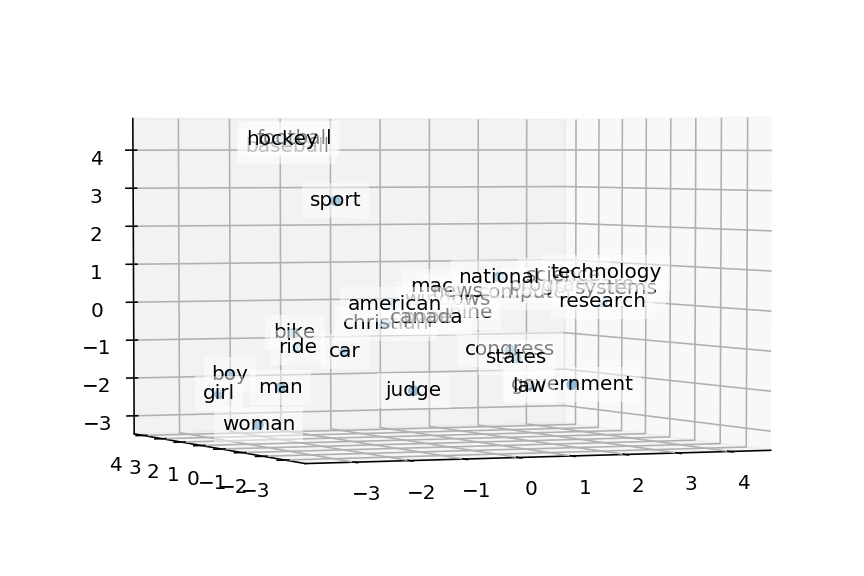

In [93]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
f = plt.figure()
ax = Axes3D(f)
#f, ax = plt.subplots(1, figsize = (16, 7))
ax.scatter(vector_map[:, 0], vector_map[:, 1], vector_map[:, 2])
for i, m in enumerate(vector_map):
    ax.text(m[0], m[1],m[2], words[i], ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.5, lw=0))

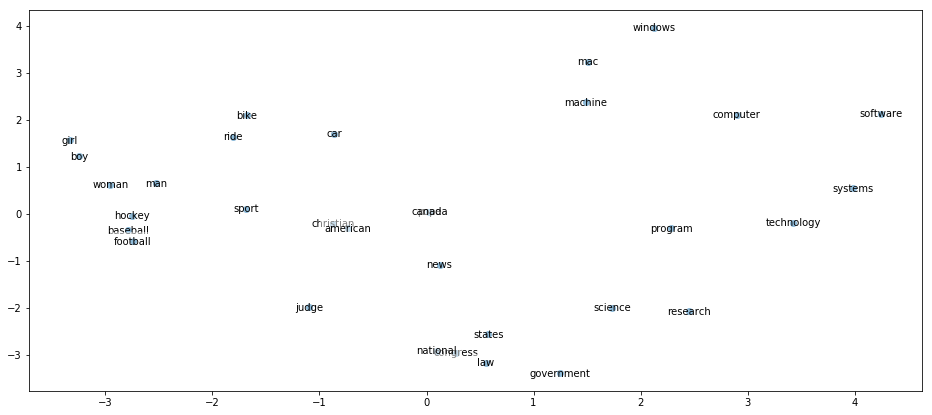

In [95]:
%matplotlib inline
f, ax = plt.subplots(1, figsize = (16, 7))
plt.scatter(vector_map[:, 0], vector_map[:, 1])
for i, m in enumerate(vector_map):
    plt.text(m[0], m[1], words[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))